In [18]:
from neo4j import GraphDatabase
import time

In [19]:
# Get Connection to neo4j

uri = 'bolt://localhost:7687'
username = 'neo4j'
password = 'graph'

neo4j_driver = GraphDatabase.driver(uri, auth=(username,password))

In [88]:
# DATA IS LOADED USING neo4j-import tool

#AuthEvents = "LOAD CSV WITH HEADERS FROM 'file:///2v_200.csv' AS row MERGE (m:Devices {Name:row.src}) MERGE (n:Devices {Name:row.destination}) MERGE (m) -[:AuthEvents {epoch_time:toInteger(row.epoch_time), event_id:toInteger(row.event_id), log_host:row.log_host, logon_type:toInteger(row.logon_type), logon_type_description:row.logon_type_description, user_name:row.user_name, domain_name:row.domain_name, logon_id:row.logon_id, subject_user_name:row.subject_user_name, subject_domain_name:row.subject_domain_name, subject_logon_id:row.subject_logon_id, status:row.status, service_name:row.service_name, authentication_package:row.authentication_package, failure_reason:row.failure_reason, process_name:row.process_name, process_id:toInteger(row.process_id), parent_process_name:row.parent_process_name, parent_process_id:toInteger(row.parent_process_id) }]-> (n)"

#start = time.time()
#with neo4j_driver.session() as neo4j_Session:
#    neo4j_Session.run(AuthEvents)
#print()

In [89]:
# DATA IS LOADED USING neo4j-import tool

#Netflow = "LOAD CSV WITH HEADERS FROM 'file:///nf_200.csv' AS row MERGE (m:Devices {Name:row.src_device}) MERGE (n:Devices {Name:row.dst_device}) MERGE (m) -[:Netflow { epoch_time:toInteger(row.epoch_time), duration:toInteger(row.duration), protocol:toInteger(row.protocol), src_port:toInteger(row.src_port), dst_port:toInteger(row.dst_port), src_packets:toInteger(row.src_packets), dst_packets:toInteger(row.dst_packets), src_bytes:toInteger(row.src_bytes), dst_bytes:toInteger(row.dst_bytes) }]-> (n)"

#start = time.time()
#with neo4j_driver.session() as neo4j_Session:
#    neo4j_Session.run(Netflow)


In [20]:
# Windows event ID 4768 - TGT request in DC. 
# This TGT(event) will be forged in case of an attack using tools like mimikatz 
# and will not be logged in DC.


# If AuthEvents edge has event id = 4768 then create tgt_req_events egde between those nodes.
Tgt_Query = """MATCH (n1:Devices)-[r:AuthEvents]->(n2:Devices) 
WHERE r.event_id = 4768 
CREATE (n1)-[r1:tgt_req_events 
             {epoch_time:r.epoch_time, 
              event_id:r.event_id,log_host:r.log_host, 
              logon_type:r.logon_type, logon_type_description:r.logon_type_description, 
              user_name:r.user_name,domain_name:r.domain_name, 
              logon_id:r.logon_id,subject_user_name:r.subject_user_name, 
              subject_domain_name:r.subject_domain_name, 
              subject_logon_id:r.subject_logon_id, status:r.status, 
              src:r.src, service_name:r.service_name, 
              destination:r.destination, authentication_package:r.authentication_package,
              failure_reason: r.failure_reason, process_name:r.process_name,
              process_id:r.process_id, parent_process_name:r.parent_process_name,
              parent_process_id:r.parent_process_id,is_attack:true}]->(n2) RETURN count(*)"""

with neo4j_driver.session() as neo4j_Session:
    result1 = neo4j_Session.run(Tgt_Query)

print(result1.data())

[{'count(*)': 75054}]


In [21]:
# Windows event ID 4769 - Service ticket request in DC

# If AuthEvents edge has event id = 4769 then create service_ticket_req egde between those nodes.
Str_Query = """MATCH (n1:Devices)-[r:AuthEvents]->(n2:Devices) 
WHERE r.event_id = 4769 
CREATE (n1)-[r1:service_ticket_req 
            {epoch_time:r.epoch_time, event_id:r.event_id, 
            log_host:r.log_host, logon_type:r.logon_type,
            logon_type_description:r.logon_type_description, 
            user_name:r.user_name, domain_name:r.domain_name, 
            logon_id:r.logon_id, subject_user_name:r.subject_user_name, 
            subject_domain_name:r.subject_domain_name, 
            subject_logon_id:r.subject_logon_id, 
            status:r.status, src:r.src, 
            service_name:r.service_name, destination:r.destination, 
            authentication_package:r.authentication_package, failure_reason: r.failure_reason, 
            process_name:r.process_name, process_id:r.process_id, 
            parent_process_name:r.parent_process_name, parent_process_id:r.parent_process_id, 
            is_attack:true}]->(n2) RETURN count(*)"""

with neo4j_driver.session() as neo4j_Session:
    result2 = neo4j_Session.run(Str_Query)

print(result2.data())

[{'count(*)': 140154}]


In [42]:
# filtering with port no. 135 & 445.
# If NetFlow edge has dst_port=135 or 445 then Create LMFlow edge between those nodes.
# These are the ports used by Empire malware for Lateral Movement.

Port_Query = """MATCH (v0:Devices)-[edge:Netflow]->(v1:Devices) 
WHERE edge.dst_port=135 OR edge.dst_port=445 
CREATE (v0)-[e:LMFlow 
             {epoch_time : edge.epoch_time, duration : edge.duration, 
              protocol : edge.protocol, src_port : edge.src_port, 
              dst_port : edge.dst_port}]->(v1) RETURN count(*)"""

with neo4j_driver.session() as neo4j_Session:
    result3 = neo4j_Session.run(Port_Query)

print(result3.data())

[{'count(*)': 53272}]


In [6]:
# If with in past 1hr of service_ticket_req(4769), we find tgt_req_events(4678)
# Then that service_ticket_req is genuine. is_attack is set to false for this case.

# Otherwise tgt_req_events(4678) is considered to be forged by tools like mimikatz 
# and not logged in DC.

epoch_time_threshold = 2000

Valid_tgt = """MATCH (n1:Devices)-[r1:service_ticket_req]->(n2:Devices) 
MATCH (n1)-[r2:tgt_req_events]->(n2) 
WHERE r2.epoch_time <= r1.epoch_time 
AND r1.epoch_time - r2.epoch_time < {0} 
SET r1.is_attack=false 
limit 100000
RETURN count(r1)""".format(epoch_time_threshold)

with neo4j_driver.session() as neo4j_Session:
    result4 = neo4j_Session.run(Valid_tgt)

print(result4.data())

[{'count(r1)': 471693776}]


In [44]:
# Lateral Movement after service_ticket_req

hop_threshold = 300

Final = """MATCH (n1:Devices)-[r1:service_ticket_req]->(n2:Devices) 
MATCH (n1)-[r2:LMFlow]->(n3:Devices) 
WHERE r1.is_attack=true 
AND n2 <> n3 
AND r1.epoch_time <= r2.epoch_time 
AND r2.epoch_time - r1.epoch_time < {0}
RETURN n1.src,n2.src,n3.src,r1.epoch_time,r2.epoch_time""".format(hop_threshold)

with neo4j_driver.session() as neo4j_Session:
    result =  neo4j_Session.run(Final)

#print(result.data()[0:10])

In [8]:
import pandas as pd

df = pd.DataFrame(result.data())

df.head()

/root/Python_3_7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,n1.src,n2.src,n3.src,r1.epoch_time,r2.epoch_time
0,Comp881331,ActiveDirectory,Comp354767,7257650,7257678
1,Comp542891,ActiveDirectory,Comp712936,7258053,7258110
2,Comp542891,ActiveDirectory,Comp712936,7258053,7258350
3,Comp542891,ActiveDirectory,Comp712936,7258053,7258291
4,Comp542891,ActiveDirectory,Comp712936,7258053,7258171


In [14]:
df_plot = df[0:100]
df_plot.head()

,n1.src,n2.src,n3.src,r1.epoch_time,r2.epoch_time
0,Comp881331,ActiveDirectory,Comp354767,7257650,7257678
1,Comp542891,ActiveDirectory,Comp712936,7258053,7258110
2,Comp542891,ActiveDirectory,Comp712936,7258053,7258350
3,Comp542891,ActiveDirectory,Comp712936,7258053,7258291
4,Comp542891,ActiveDirectory,Comp712936,7258053,7258171


In [15]:
import networkx as nx
import matplotlib.pyplot as plt

attr = ["r1.epoch_time","r2.epoch_time"]
G=nx.from_pandas_edgelist(df_plot, source='n1.src', target='n3.src', edge_attr=attr, create_using=nx.MultiDiGraph())


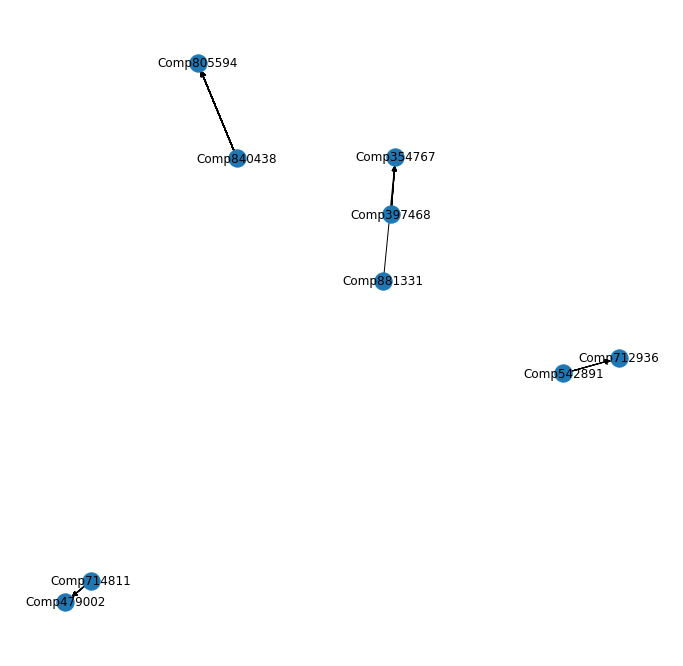

In [17]:
plt.figure(figsize=(12, 12))
layout = nx.spring_layout(G,iterations=50)
plt.axis('off')
nx.draw(G,pos=layout )
nx.draw_networkx_labels(G,pos=layout)
#nx.draw_networkx_edge_labels(G,pos=layout)
plt.draw()